In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import modf

%matplotlib inline

Описание датасета:

Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры 

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'train_prep.csv'

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
# Преобразуем все категориальные признаки датасета

df = pd.get_dummies(df)

In [5]:
# Изменим тип данных в датасете и удалим столбец Id

df = df.astype(dtype='float64')
df = df.drop(labels='Id', axis='columns')

In [6]:
# Проанализируем уникальность значений каждого признака

df.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Price            10000
Ecology_2_A          2
Ecology_2_B          2
Ecology_3_A          2
Ecology_3_B          2
Shops_2_A            2
Shops_2_B            2
dtype: int64

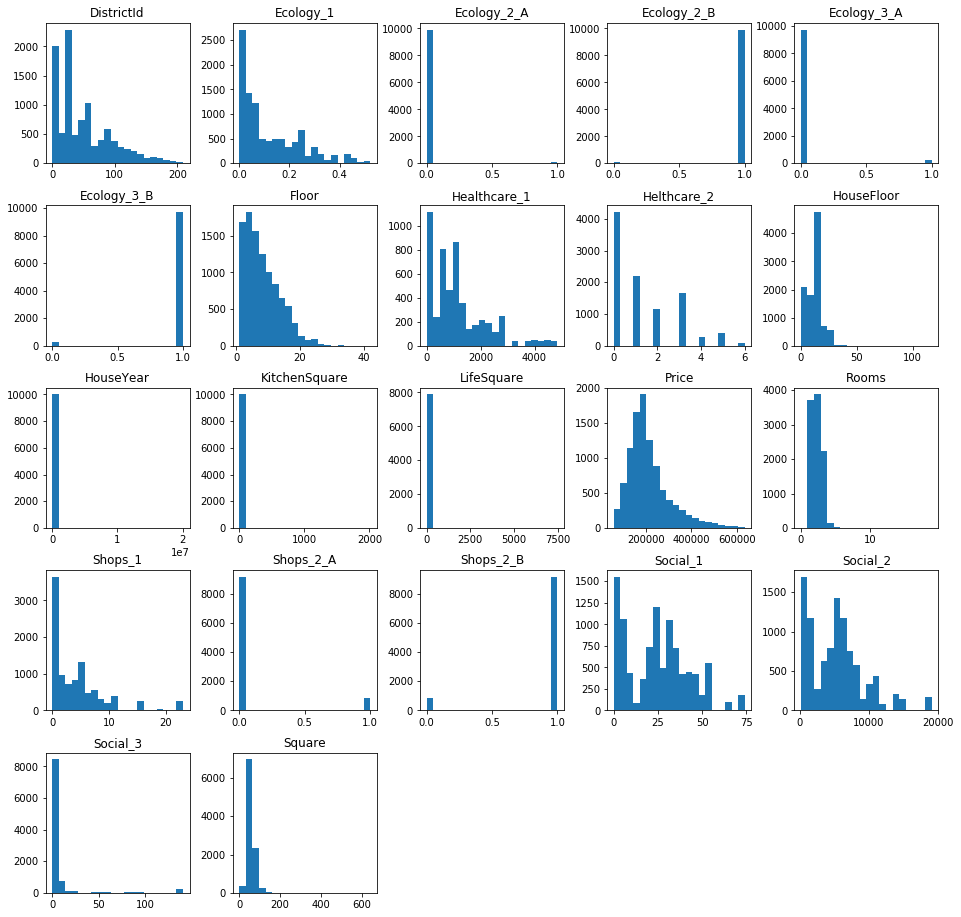

In [7]:
# Визуализируем все для признаки для предварительного визуального анализа

df_num_features = df.select_dtypes(include='float')
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

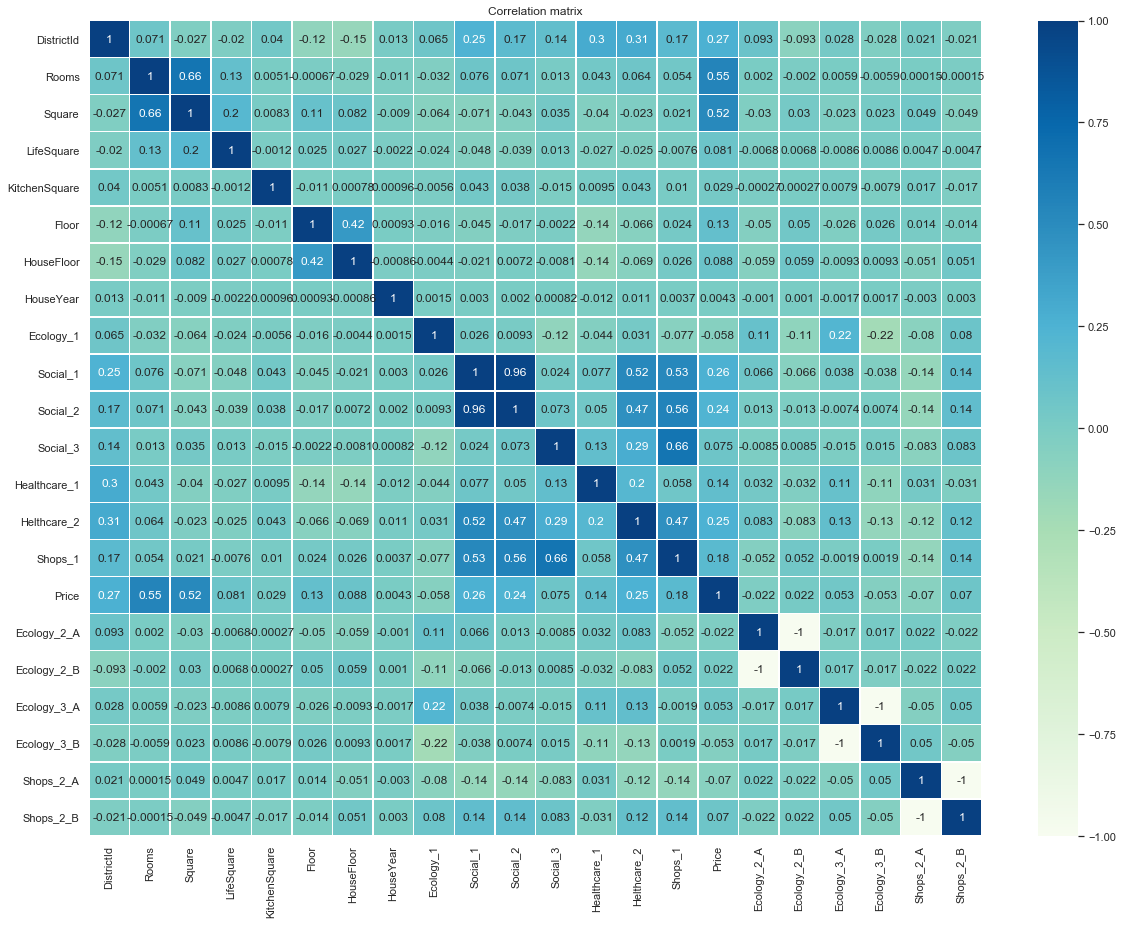

In [8]:
# Построим матрицу корреляций признаков

plt.figure(figsize = (20,15))

sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [9]:
# Создаем выборку где LifeSquare определена и имеет значение не более чем общая площадь. Будем использовать ее для тренировки модели

df_train_LS = df.loc[(df['LifeSquare'] <= df['Square'])]

X = df_train_LS[['Rooms', 'Floor', 'Square','Floor','HouseFloor']]
y = df_train_LS['LifeSquare']

In [10]:
# Создаем валидационную выборку где LifeSquare NaN или имеют значения больше чем Square (то что требуется заполнить)

df_valid_LS = df.loc[(df['LifeSquare'].isna()) | (df['LifeSquare'] > df['Square'])].drop(labels='Healthcare_1', axis=1)
X_valid = df_valid_LS[['Rooms', 'Floor', 'Square','Floor','HouseFloor']]

# Для получения индексов пропущенных значений создадим переменную

y_valid_LS = df_valid_LS['LifeSquare']

y_valid_LS.shape

(2595,)

In [11]:
# Разобьем тренировочный датасет df_train_LS на тренировочные и тестовые данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

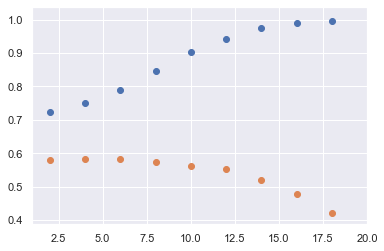

In [12]:
# Подберем параметр max_depth для нашей модели предсказания LifeSquare

r2_train = []
r2_test = []
for i in range(2,20,2):
    rf_model = GradientBoostingRegressor(max_depth=i, n_estimators=30)
    rf_model.fit(X_train, y_train)
    pred_train_ = rf_model.predict(X_train)
    pred_test_ = rf_model.predict(X_test)
    r2_train.append(r2_score(y_train, pred_train_))
    r2_test.append(r2_score(y_test,pred_test_))
    
# И построим зависимость r2  от значения max_depth

plt.scatter(list(range(2,20,2)), r2_train)
plt.scatter(list(range(2,20,2)), r2_test)
plt.xlim(1,20)
plt.grid(1)

In [13]:
# Подберем наилучшие гиперпараметры модели предсказания LifeSquare

params = {'random_state':list(range(1,100,10)), 
          'n_estimators':list(range(1,100,20))}

gs = GridSearchCV(rf_model, params, scoring='r2', cv=4, n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=18,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=30,
                                                 n_iter_no_change=None,
                 

In [14]:
# Определим лучшие параметры

gs.best_params_

{'n_estimators': 21, 'random_state': 41}

In [15]:
# Переобучим модель на всех тренировчных данных и предскажем LifeSquare

final_model_LS = RandomForestRegressor(n_estimators=21, max_depth=5, random_state=41)
final_model_LS.fit(X, y)

y_pred_LS = final_model_LS.predict(X_valid)

In [16]:
# Создадим датафрейм с индексами значений которые будем заменять

y_pred_LS = pd.DataFrame(y_pred_LS, index=y_valid_LS.index)
y_pred_LS.head()

,0
7,45.496410
8,40.601442
21,35.971625
23,62.799261
25,52.752248


In [17]:
# Проведем объединение предсказанных данных с имеющимися, заполнив пропущенные значения и те которые больше Square

temp_df = pd.concat((y, y_pred_LS), axis=0)
df['LifeSquare'] = temp_df
df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,...,NaN,0.0,11.0,184966.930730,0.0,1.0,0.0,1.0,0.0,1.0
1,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,...,240.0,1.0,16.0,300009.450063,0.0,1.0,0.0,1.0,0.0,1.0
2,53.0,2.0,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,34.0,...,229.0,1.0,3.0,220925.908524,0.0,1.0,0.0,1.0,0.0,1.0
3,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,23.0,...,1084.0,0.0,5.0,175616.227217,0.0,1.0,0.0,1.0,0.0,1.0
4,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,...,2078.0,2.0,4.0,150226.531644,0.0,1.0,0.0,1.0,0.0,1.0
5,59.0,3.0,80.384479,46.683720,12.0,5.0,17.0,2011.0,0.309479,35.0,...,990.0,0.0,6.0,215898.447742,0.0,1.0,0.0,1.0,0.0,1.0
6,154.0,2.0,62.254114,37.160377,7.0,3.0,5.0,1960.0,0.460556,20.0,...,NaN,1.0,5.0,296021.204377,0.0,1.0,0.0,1.0,0.0,1.0
7,74.0,2.0,80.312926,45.496410,0.0,14.0,0.0,1977.0,0.075779,6.0,...,NaN,0.0,2.0,221244.156664,0.0,1.0,0.0,1.0,0.0,1.0
8,1.0,2.0,64.511437,40.601442,1.0,9.0,17.0,1977.0,0.007122,1.0,...,NaN,0.0,1.0,229102.795999,0.0,1.0,0.0,1.0,0.0,1.0
9,23.0,1.0,46.461409,18.915552,8.0,13.0,17.0,2014.0,0.075779,6.0,...,NaN,0.0,2.0,95380.220993,0.0,1.0,0.0,1.0,0.0,1.0


In [18]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,35.105817,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,...,1142.904460,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.839512,21.058732,17.693762,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,...,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,23.212280,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,...,350.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,32.564822,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,65.900625,43.500939,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,...,1548.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Заменим значения LifeSquare < 0 на разницу Square и KitchenSquare

df.loc[(df['LifeSquare'] < 0), ['LifeSquare']] = df['Square'] - df['KitchenSquare']

In [20]:
# Проанализируем значения KitchenSquare и заменим значения KitchenSquare которые больше Square

df.loc[(df['KitchenSquare'] > df['Square']), ['KitchenSquare']] = df['Square'] - df['LifeSquare']

In [21]:
# Проанализируем значения HouseYear на выбросы

df.loc[((df['HouseYear'] > 2020) | (df['HouseYear'] < 1900)), ['HouseYear']]

,HouseYear
1497,20052011.0
4189,4968.0


In [22]:
# Заменим выбросы на медиану

df.loc[(df['HouseYear'] == 20052011), ['HouseYear']] = 2011
df.loc[(df['HouseYear'] == 4968), ['HouseYear']] = df['HouseYear'].median()

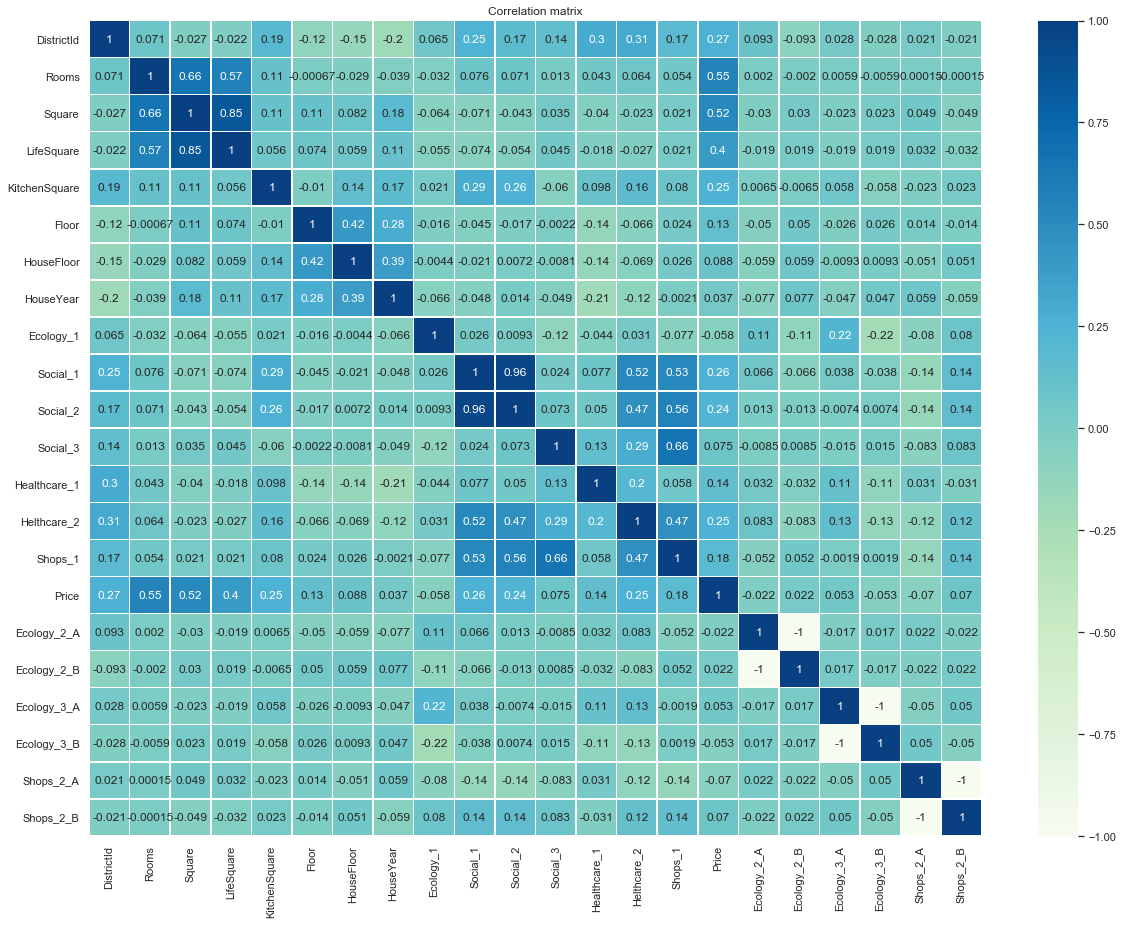

In [23]:
# Визуализируем повторно матрицу корреляции для оценки изменений

plt.figure(figsize = (20,15))

sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [24]:
# Удалим столбцы с низкой корреляцией к признаку Price

df = df.drop(labels=['Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'], axis='columns')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  float64
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  float64
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  float64
 8   Social_1       10000 non-null  float64
 9   Social_2       10000 non-null  float64
 10  Social_3       10000 non-null  float64
 11  Healthcare_1   5202 non-null   float64
 12  Helthcare_2    10000 non-null  float64
 13  Shops_1        10000 non-null  float64
 14  Price          10000 non-null  float64
 15  Ecology_3_A    10000 non-null  float64
dtypes: float64(16)
memory usage: 1.2 MB


In [26]:
# Подготовка данных Healthcare_1 

X_train_health_ = df.loc[df['Healthcare_1'].notnull()]
y_train_health = X_train_health_['Healthcare_1']
X_train_health = X_train_health_.drop(axis=1, labels=['Price', 'Healthcare_1'])

X_test_health_ = df.loc[df['Healthcare_1'].isnull()]
y_test_health = X_test_health_['Healthcare_1']
X_test_health = X_test_health_.drop(axis=1, labels=['Price', 'Healthcare_1'])

In [27]:
# Предскажем по тренировочной выборке значения параметра Healthcare_1

rf_model_H = RandomForestRegressor(max_depth=6, n_estimators= 10)
rf_model_H.fit(X_train_health, y_train_health)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [28]:
pred_train_H = rf_model_H.predict(X_train_health)

In [29]:
r2_score(y_train_health, pred_train_H)

0.8340139031526036

In [30]:
# Используя полученную модель предскажем значения Healthcare_1

y_pred_health = rf_model_H.predict(X_test_health)

In [31]:
# Создадим DataFrame на основе массива предсказанных данных и присвоим индексы согласно первоначальной тестовой выборки

y_pred_df = pd.DataFrame(y_pred_health, index=X_test_health_.index, columns=['Healthcare_1'])
y_pred_df.head()

,Healthcare_1
0,955.079604
6,787.456193
7,878.329657
8,509.716643
9,899.121020


In [32]:
# Провелем объединение предсказанных данных с имеющимися, заполнив пропущенные значения

temp_df = pd.concat((y_train_health, y_pred_df['Healthcare_1']), axis=0)
df['Healthcare_1'] = temp_df
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_3_A
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,35.105817,5.864350,8.526700,12.609400,1984.867200,24.687000,5352.157400,8.039200,1014.435812,1.319500,4.231300,214138.857399,0.027500
std,43.587592,0.839512,21.058732,17.693762,5.074565,5.241148,6.775974,18.411666,17.532614,4006.799803,23.831875,849.351011,1.493601,4.806341,92872.293865,0.163543
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,20.000000,1.000000,41.774881,23.212280,1.000000,4.000000,9.000000,1974.000000,6.000000,1564.000000,0.000000,482.114112,0.000000,1.000000,153872.633942,0.000000
50%,36.000000,2.000000,52.513310,32.564822,6.000000,7.000000,13.000000,1977.000000,25.000000,5285.000000,2.000000,750.000000,1.000000,3.000000,192269.644879,0.000000
75%,75.000000,2.000000,65.900625,43.500939,9.000000,12.000000,17.000000,2001.000000,36.000000,7227.000000,5.000000,1199.137355,2.000000,6.000000,249135.462171,0.000000
max,209.000000,19.000000,641.065193,638.163193,123.000000,42.000000,117.000000,2020.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


In [33]:
# Сохраним обучающий датасет

df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [34]:
feature_names = df.columns.drop('Price')
target_name = df.columns.drop(feature_names)

X = df[feature_names]
y = df[target_name]

In [35]:
# Разобьем датасет на тренировочный и тестовый 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

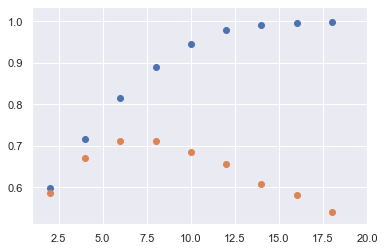

In [36]:
# Подберем параметр max_depth для нашей модели предсказания Healthcare_1

r2_train = []
r2_test = []
for i in range(2,20,2):
    rf_model = GradientBoostingRegressor(max_depth=i, n_estimators=30)
    rf_model.fit(X_train, y_train)
    pred_train_ = rf_model.predict(X_train)
    pred_test_ = rf_model.predict(X_test)
    r2_train.append(r2_score(y_train, pred_train_))
    r2_test.append(r2_score(y_test,pred_test_))
    
# И построим зависимость r2  от значения max_depth

plt.scatter(list(range(2,20,2)), r2_train)
plt.scatter(list(range(2,20,2)), r2_test)
plt.xlim(1,20)
plt.grid(1)

### Настройка и оценка финальной модели

In [37]:
params = {'random_state':list(range(1,100,10)), 
          'n_estimators':list(range(1,100,20))}

gs = GridSearchCV(rf_model, params, scoring='r2', cv=4, n_jobs=-1)
gs.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=18,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=30,
                                                 n_iter_no_change=None,
                 

In [38]:
# лучшие параметры

gs.best_params_

{'n_estimators': 21, 'random_state': 31}

**Обучение и оценка модели**

In [98]:
final_model = RandomForestRegressor(n_estimators=21, max_depth=6, random_state=31)
final_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=21, n_jobs=None, oob_score=False,
                      random_state=31, verbose=0, warm_start=False)

In [67]:
# Предскажем значения цены на объекты 

y_train_P = final_model.predict(X_train)
r2_score(y_train, y_train_P)

0.6971943663251374

In [68]:
# Переучим модель на всех данных датасета

final_model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=21, n_jobs=None, oob_score=False,
                      random_state=31, verbose=0, warm_start=False)

In [69]:
# Загрузим тестовый датасет и проведем подготовим данные по аналогии с датасетом train

TEST_DATASET_PATH = 'test.csv'
PREPARED_TEST_DATASET_PATH = 'test_prep.csv'

In [70]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [71]:
# Преобразуем все категориальные признаки датасета

df_test = pd.get_dummies(df_test)

In [72]:
# Изменим тип данных в датасете и удалим столбец Id

df_test = df_test.astype(dtype='float64')
df_test = df_test.drop(labels='Id', axis='columns')
df_test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,58.0,2.0,49.882643,33.432782,6.0,6.0,14.0,1972.0,0.310199,11.0,...,1.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,74.0,2.0,69.263183,NaN,1.0,6.0,1.0,1977.0,0.075779,6.0,...,3.0,NaN,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0
2,190.0,1.0,13.597819,15.948246,12.0,2.0,5.0,1909.0,0.000000,30.0,...,87.0,4702.0,5.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0
3,47.0,2.0,73.046609,51.940842,9.0,22.0,22.0,2007.0,0.101872,23.0,...,3.0,NaN,3.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0
4,27.0,1.0,47.527111,43.387569,1.0,17.0,17.0,2017.0,0.072158,2.0,...,1.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11.0,3.0,67.133911,50.809797,6.0,5.0,9.0,1973.0,0.000170,36.0,...,0.0,NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4996,1.0,1.0,40.198472,21.807061,10.0,12.0,17.0,2017.0,0.007122,1.0,...,0.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4997,12.0,3.0,77.842178,48.282625,9.0,23.0,22.0,1989.0,0.090799,74.0,...,2.0,NaN,5.0,15.0,0.0,1.0,0.0,1.0,0.0,1.0
4998,62.0,2.0,81.305222,NaN,0.0,4.0,0.0,1977.0,0.072158,2.0,...,1.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [73]:
# Проанализируем уникальность значений каждого признака

df_test.nunique()

DistrictId        201
Rooms               8
Square           5000
LifeSquare       3959
KitchenSquare      38
Floor              35
HouseFloor         41
HouseYear          97
Ecology_1         130
Social_1           51
Social_2          143
Social_3           30
Healthcare_1       79
Helthcare_2         7
Shops_1            16
Ecology_2_A         2
Ecology_2_B         2
Ecology_3_A         2
Ecology_3_B         2
Shops_2_A           2
Shops_2_B           2
dtype: int64

In [74]:
# Создаем выборку где LifeSquare определена и имеет значение не более чем общая площадь. Будем использовать ее для тренировки модели

df_test_LS = df_test.loc[(df_test['LifeSquare'] <= df_test['Square'])]

X = df_test_LS[['Rooms', 'Floor', 'Square','Floor','HouseFloor']]
y = df_test_LS['LifeSquare']

In [75]:
# Создаем валидационную выборку где LifeSquare NaN или имеют значения больше чем Square (то что требуется заполнить)

df_valid_LS_test = df_test.loc[(df_test['LifeSquare'].isna()) | (df_test['LifeSquare'] > df_test['Square'])].drop(labels='Healthcare_1', axis=1)
X_valid_test = df_valid_LS_test[['Rooms', 'Floor', 'Square','Floor','HouseFloor']]

# Для получения индексов пропущенных значений создадим переменную

y_valid_LS_test = df_valid_LS_test['LifeSquare']

In [76]:
# Предскажем значения LifeSquare

y_pred_LS_test = final_model_LS.predict(X_valid_test)

In [77]:
# Создадим датафрейм с индексами значений которые будем заменять

y_pred_LS_test = pd.DataFrame(y_pred_LS_test, index=df_valid_LS_test.index)
y_pred_LS_test.shape

(1282, 1)

In [78]:
# Проведем объединение предсказанных данных с имеющимися, заполнив пропущенные значения и те которые больше Square

temp_df_test = pd.concat((y, y_pred_LS_test), axis=0)
df_test['LifeSquare'] = temp_df_test

df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,35.080148,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,...,8.262600,1146.657263,1.31940,4.242800,0.009600,0.990400,0.029800,0.970200,0.082400,0.917600
std,44.179466,0.838594,19.092787,15.104240,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,...,23.863762,1044.744231,1.47994,4.777365,0.097518,0.097518,0.170052,0.170052,0.275001,0.275001
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,23.459539,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,...,0.000000,325.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,37.000000,2.000000,52.921340,32.999298,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,...,2.000000,900.000000,1.00000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,77.000000,2.000000,66.285129,43.677993,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,...,5.000000,1548.000000,2.00000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,212.000000,17.000000,223.453689,136.921090,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,...,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
# Заменим значения LifeSquare < 0 на разницу Square и KitchenSquare

df_test.loc[(df_test['LifeSquare'] < 0), ['LifeSquare']] = df_test['Square'] - df_test['KitchenSquare']

In [80]:
# Проанализируем значения KitchenSquare и заменим значения KitchenSquare которые больше Square

df_test.loc[(df_test['KitchenSquare'] > df_test['Square']), ['KitchenSquare']] = df_test['Square'] - df_test['LifeSquare']

In [81]:
# Проанализируем значения HouseYear на выбросы

df_test.loc[((df_test['HouseYear'] > 2020) | (df_test['HouseYear'] < 1900)), ['HouseYear']]

,HouseYear


In [82]:
# Удалим столбцы с низкой корреляцией к признаку Price

df_test = df_test.drop(labels=['Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_B',
                               'Shops_2_A', 'Shops_2_B'], axis='columns')

In [83]:
# Подготовка данных Healthcare_1 

X_train_health_ = df_test.loc[df_test['Healthcare_1'].notnull()]
y_train_health = X_train_health_['Healthcare_1']
X_train_health = X_train_health_.drop(axis=1, labels='Healthcare_1')

X_test_health_ = df_test.loc[df_test['Healthcare_1'].isnull()]
y_test_health = X_test_health_['Healthcare_1']
X_test_health = X_test_health_.drop(axis=1, labels='Healthcare_1')

In [84]:
# Используя полученную ранее модель предскажем значения Healthcare_1

y_pred_health = rf_model_H.predict(X_test_health)

In [85]:
# Создадим DataFrame на основе массива предсказанных данных и присвоим индексы согласно первоначальной тестовой выборки

y_pred_df = pd.DataFrame(y_pred_health, index=X_test_health_.index, columns=['Healthcare_1'])
y_pred_df.head()

,Healthcare_1
0,380.834393
1,878.329657
3,1158.978208
4,392.428354
6,899.121020


In [86]:
# Проведем объединение предсказанных данных с имеющимися, заполнив пропущенные значения

temp_df = pd.concat((y_train_health, y_pred_df['Healthcare_1']), axis=0)
df_test['Healthcare_1'] = temp_df
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_3_A
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,35.080148,5.830664,8.632000,12.601000,1984.392600,24.933800,5406.900000,8.262600,1016.272774,1.31940,4.242800,0.029800
std,44.179466,0.838594,19.092787,15.104240,4.644416,5.483228,6.789213,18.573149,17.532202,4026.614773,23.863762,868.141536,1.47994,4.777365,0.170052
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,23.459539,1.000000,4.000000,9.000000,1973.000000,6.000000,1564.000000,0.000000,482.114112,0.00000,1.000000,0.000000
50%,37.000000,2.000000,52.921340,32.999298,6.000000,7.000000,12.000000,1977.000000,25.000000,5285.000000,2.000000,750.000000,1.00000,3.000000,0.000000
75%,77.000000,2.000000,66.285129,43.677993,9.000000,12.000000,17.000000,2000.000000,36.000000,7287.000000,5.000000,1199.137355,2.00000,6.000000,0.000000
max,212.000000,17.000000,223.453689,136.921090,112.000000,78.000000,99.000000,2020.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


In [87]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   float64
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   float64
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   float64
 8   Social_1       5000 non-null   float64
 9   Social_2       5000 non-null   float64
 10  Social_3       5000 non-null   float64
 11  Healthcare_1   5000 non-null   float64
 12  Helthcare_2    5000 non-null   float64
 13  Shops_1        5000 non-null   float64
 14  Ecology_3_A    5000 non-null   float64
dtypes: float64(15)
memory usage: 586.1 KB


In [88]:
# Сохраним тестовый датасет

df_test.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

In [99]:
# Окончательно спрогнозируем цены по тестовому датасету

# final_model = RandomForestRegressor(n_estimators=21, max_depth=6, random_state=31)
y_test_P_final = final_model.predict(df_test)

In [100]:
# Создадим итоговый датасет с предсказанными ценами

df_test['Id'] = pd.read_csv(TEST_DATASET_PATH)['Id']
df_test['Price'] = y_test_P_final

In [102]:
# Загрузим итоговый датасет в файл first_pridict.csv

df_test[['Id', 'Price']].to_csv('KShein_pridiction.csv', index=False)